# Consistency analysis on PPMI results

## Demographics



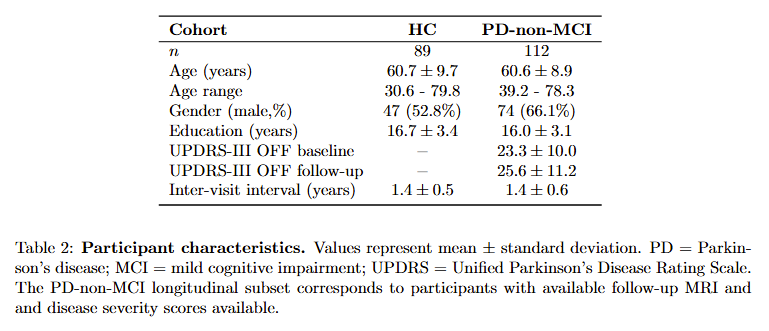

## Consistency

In [ ]:
import pandas as pd
from pathlib import Path

anonymizer = True

root_dir = Path.cwd().parent.parent.parent.parent
# root_dir = Path().cwd() / "freesurfer-fuzzy"

def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Running in root dir: {anondir(root_dir)}")
npv_dir = root_dir / "npv" / "csv_all"
print(f"Using NPV dir: {anondir(npv_dir)}")
data_dir = root_dir / "notebooks" / "papers_data" / "parkinson" / "Current"
print(f"Using data dir: {anondir(data_dir)}")

Running in root dir: <living-park>
Using NPV dir: <living-park>/npv/csv_all
Using data dir: <living-park>/notebooks/papers_data/parkinson/Current


### Load NPV maps

In [8]:
npv_thickness = pd.read_csv(npv_dir / "npv_hc-pd_baseline_thickness.csv")
npv_thickness_pd = pd.read_csv(npv_dir / "npv_pd_baseline_thickness.csv")
npv_thickness_long = pd.read_csv(npv_dir / "npv_hc-pd_thickness_longitudinal.csv")

npv_area = pd.read_csv(npv_dir / "npv_hc-pd_baseline_area.csv")
npv_area_pd = pd.read_csv(npv_dir / "npv_pd_baseline_area.csv")
npv_area_long = pd.read_csv(npv_dir / "npv_hc-pd_area_longitudinal.csv")

npv_volume = pd.read_csv(npv_dir / "npv_hc-pd_baseline_volume.csv")
npv_volume_pd = pd.read_csv(npv_dir / "npv_pd_baseline_volume.csv")
npv_volume_long = pd.read_csv(npv_dir / "npv_hc-pd_volume_longitudinal.csv")


npv_subcortical_volume = pd.read_csv(
    npv_dir / "npv_hc-pd_baseline_subcortical_volume.csv"
)
npv_subcortical_volume_pd = pd.read_csv(
    npv_dir / "npv_pd_baseline_subcortical_volume.csv"
)
npv_subcortical_volume_long = pd.read_csv(
    npv_dir / "npv_hc-pd_subcortical_volume_longitudinal.csv"
)

### Formula

In [9]:
import numpy as np
import scipy.stats


# ANCOVA
def std_F(F, npv):
    return 2 * np.sqrt(F) * npv


def std_p_F(F, df, npv):
    return 2 * np.sqrt(F) * scipy.stats.f.pdf(F, dfn=1, dfd=df) * npv


# T-test
def std_t(npv):
    return npv


def std_p_t(t, df, npv):
    return 2 * scipy.stats.t.pdf(np.abs(t), df) * npv


# Partial correlation
def std_r(r, n, npv):
    return np.sqrt((1 - r**2) ** 3 / (n - 1)) * npv


def std_p_r(r, n, npv):
    t = r * np.sqrt((n - 2) / (1 - r**2))
    return 2 * scipy.stats.t.pdf(np.abs(t), n - 2) * np.sqrt(((n - 2) / (n - 1))) * npv

In [10]:
import pandas as pd
from scipy.stats import beta
import numpy as np


def beta_params_from_mean_var(mu, var, eps=1e-12):
    """Return (a,b) for Beta by moment matching. Clamps var to < mu(1-mu)."""
    max_var = mu * (1 - mu) - eps
    # Clamp var for non-degenerate cases
    var_clamped = np.minimum(var, max_var)

    # Calculate k for non-degenerate cases
    # Ensure we don't divide by zero if var_clamped becomes zero due to clamping
    # This can happen if mu*(1-mu) is very small and var is also very small but positive.
    # The original code implicitly handles this by setting k=1e6 when var<=0.
    # Here, we ensure that if var_clamped is effectively zero, k is large.
    # A small positive value for the denominator to avoid division by zero for k calculation
    denominator = np.where(var_clamped == 0, eps, var_clamped)
    k_calculated = mu * (1 - mu) / denominator - 1.0
    # Ensure k is not negative, as it should be > 0 for Beta distribution
    k_calculated = np.maximum(k_calculated, eps)  # k must be > 0

    a_calculated = mu * k_calculated
    b_calculated = (1 - mu) * k_calculated

    return a_calculated, b_calculated


def flip_proba_beta(p0, sigma_P, alpha=0.05):
    """
    Flip probability at alpha with P ~ Beta(a,b).
    Provide either sigma_P.
    Works with pandas Series/DataFrames.
    """
    var_P = sigma_P**2
    a, b = beta_params_from_mean_var(p0, var_P)

    # Determine the flip probability based on p0 relative to alpha
    # Use np.where for vectorized conditional logic
    # pflip_non_significant = 1.0 - beta.cdf(alpha, a, b) # if p0 < alpha, flip if P > alpha
    pflip_significant = beta.cdf(alpha, a, b)  # if p0 >= alpha, flip if P <= alpha

    # pflip = np.where(p0 < alpha, pflip_significant, pflip_non_significant)
    pflip = pflip_significant

    # Clip the result to ensure it's within [0, 1]
    return np.clip(pflip, 0.0, 1.0)

In [11]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


def plot_dumbbell(results, title, group=None):
    columns = [
        "region",
        "p_value",
        "npv",
        "std_p",
        "std_p_low",
        "std_p_high",
        "proba_significant",
    ] + ([] if group is None else [group])
    df = results.copy()
    df = df[columns]
    df.rename(
        columns={
            "std_p": "std_p",
            "std_r": "std_r",
            "sig": "sig",
            "p": "p_value",
            "std_p_low": "std_p_low",
            "std_p_high": "std_p_high",
            "proba_significant": "psig",
        },
        inplace=True,
    )
    df["std_p_low"] = df["std_p"] - df["std_p_low"]
    df["std_p_high"] = df["std_p_high"] - df["std_p"]

    col_label = "std_p"

    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=["p-value", "std p-value", "Probability significance"],
    )

    fig_1 = px.scatter(df, x="region", y="p_value", color=group)
    # Add lines for each dumbbell
    fig_2 = px.scatter(
        df,
        x="region",
        y="std_p",
        color=group,
        error_y="std_p_low",
        error_y_minus="std_p_high",
        labels="std_p",
    )
    fig_3 = go.Scatter(
        x=df["region"],
        y=df["psig"],
        mode="markers",
        marker_color="black",
        marker_symbol="cross",
        name="Flip probability",
        showlegend=False,
    )

    fig.add_traces(fig_1.data, rows=1, cols=1)
    fig.add_traces(fig_2.data, rows=1, cols=2)
    fig.add_traces(fig_3, rows=1, cols=3)

    fig.update_layout(
        title=title,
        yaxis_title=col_label,
        xaxis_title="Value",
        hovermode="closest",
        height=600,
        width=1400,
    )

    fig.add_hline(y=0.05, line_color="red", line_width=2, row=1, col=1)
    fig.update_yaxes(range=[-0.05, 1.05])

    return fig

### Group differences at baseline

#### Cortical surface area

In [12]:
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / "ancova_baseline_area.parquet")
ancova = ancova[~ancova.F.isna()]
ancova["metric"] = "cortical area"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "cross-sectional"
ancova["timepoint"] = "baseline"
ancova["n"] = ancova["n"].astype(int)
ancova = ancova.rename(columns={"n": "sample_size", "p-val": "p_value"})
ancova = pd.merge(ancova, npv_area, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]
ancova["significant"] = ancova["p_value"] < 0.05
ancova["std_F"] = std_F(ancova["F"], ancova["npv"])
ancova["std_p"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_low"])
ancova["std_p_high"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_high"])
ancova["proba_significant"] = flip_proba_beta(ancova["p_value"], ancova["std_p"])

ancova_baseline_area = ancova.copy()

In [13]:
plot_dumbbell(
    ancova_baseline_area,
    "Group differences between PD and HC at baseline (cortical area)",
)

#### Cortical thickness

In [14]:
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / "ancova_baseline_thickness.parquet")
ancova = ancova[~ancova.F.isna()]
ancova["metric"] = "cortical thickness"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "cross-sectional"
ancova["timepoint"] = "baseline"
ancova["n"] = ancova["n"].astype(int)
ancova.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
ancova = pd.merge(ancova, npv_thickness, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]
ancova["significant"] = ancova["p_value"] < 0.05
ancova["std_F"] = std_F(ancova["F"], ancova["npv"])
ancova["std_p"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_low"])
ancova["std_p_high"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_high"])
ancova["proba_significant"] = flip_proba_beta(ancova["p_value"], ancova["std_p"])

ancova_baseline_thickness = ancova.copy()

In [15]:
plot_dumbbell(
    ancova_baseline_thickness,
    "Group differences between PD and HC at baseline (cortical thickness)",
)

#### Cortical volume

In [16]:
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / "ancova_baseline_volume.parquet")
ancova = ancova[~ancova.F.isna()]
ancova["metric"] = "cortical volume"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "cross-sectional"
ancova["timepoint"] = "baseline"
ancova["n"] = ancova["n"].astype(int)
ancova.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
ancova = pd.merge(ancova, npv_volume, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]
ancova["significant"] = ancova["p_value"] < 0.05
ancova["std_F"] = std_F(ancova["F"], ancova["npv"])
ancova["std_p"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_low"])
ancova["std_p_high"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_high"])
ancova["proba_significant"] = flip_proba_beta(ancova["p_value"], ancova["std_p"])

ancova_baseline_volume = ancova.copy()

In [17]:
plot_dumbbell(
    ancova_baseline_volume,
    "Group differences between PD and HC at baseline (cortical volume)",
)

#### Subcortical volumes

In [18]:
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(
    parquet_dir / "ancova" / "ancova_baseline_subcortical_volume.parquet"
)
ancova = ancova[~ancova.F.isna()]
ancova["metric"] = "subcortical volume"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "cross-sectional"
ancova["timepoint"] = "baseline"
ancova["n"] = ancova["n"].astype(int)
ancova.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
ancova = pd.merge(ancova, npv_subcortical_volume, on=["region"])
ancova["significant"] = ancova["p_value"] < 0.05
ancova["std_F"] = std_F(ancova["F"], ancova["npv"])
ancova["std_p"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_low"])
ancova["std_p_high"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_high"])
ancova["proba_significant"] = flip_proba_beta(ancova["p_value"], ancova["std_p"])

ancova_baseline_subcortical_volume = ancova.copy()

In [19]:
plot_dumbbell(
    ancova_baseline_subcortical_volume,
    "Group differences between PD and HC at baseline (subcortical volume)",
)

### Group differences longitudinally

#### Cortical surface area

In [20]:
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / "ancova_longitudinal_area.parquet")
ancova = ancova[~ancova.F.isna()]
ancova["metric"] = "cortical area"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "longitudinal"
ancova["timepoint"] = "baseline+follow-up"
ancova["n"] = ancova["n"].astype(int)
ancova.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
ancova = pd.merge(ancova, npv_area_long, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]
ancova["significant"] = ancova["p_value"] < 0.05
ancova["std_F"] = std_F(ancova["F"], ancova["npv"])
ancova["std_p"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_low"])
ancova["std_p_high"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_high"])
ancova["proba_significant"] = flip_proba_beta(ancova["p_value"], ancova["std_p"])

ancova_longitudinal_area = ancova.copy()

In [21]:
plot_dumbbell(
    ancova_longitudinal_area,
    "Group differences between Parkinson's and controls longitudinally (cortical area)",
)

#### Cortical thickness

In [22]:
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(
    parquet_dir / "ancova" / "ancova_longitudinal_thickness.parquet"
)
ancova = ancova[~ancova.F.isna()]
ancova["metric"] = "cortical thickness"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "longitudinal"
ancova["timepoint"] = "baseline+follow-up"
ancova["n"] = ancova["n"].astype(int)
ancova.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
ancova = pd.merge(ancova, npv_thickness_long, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]
ancova["significant"] = ancova["p_value"] < 0.05
ancova["std_F"] = std_F(ancova["F"], ancova["npv"])
ancova["std_p"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_low"])
ancova["std_p_high"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_high"])
ancova["proba_significant"] = flip_proba_beta(ancova["p_value"], ancova["std_p"])

ancova_longitudinal_thickness = ancova.copy()

In [23]:
plot_dumbbell(
    ancova_longitudinal_thickness,
    "Group differences between Parkinson's and controls longitudinally (cortical thickness)",
)

#### Cortical volume

In [24]:
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / "ancova_longitudinal_volume.parquet")
ancova = ancova[~ancova.F.isna()]
ancova["metric"] = "cortical volume"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "longitudinal"
ancova["timepoint"] = "baseline+follow-up"
ancova["n"] = ancova["n"].astype(int)
ancova.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
ancova = pd.merge(ancova, npv_volume_long, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]
ancova["significant"] = ancova["p_value"] < 0.05
ancova["std_F"] = std_F(ancova["F"], ancova["npv"])
ancova["std_p"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_low"])
ancova["std_p_high"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_high"])
ancova["proba_significant"] = flip_proba_beta(ancova["p_value"], ancova["std_p"])

ancova_longitudinal_volume = ancova.copy()

In [25]:
plot_dumbbell(
    ancova_longitudinal_volume,
    "Group differences between Parkinson's and controls longitudinally (cortical volume)",
)

#### Subcortical volumes

In [26]:
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(
    parquet_dir / "ancova" / "ancova_longitudinal_subcortical_volume.parquet"
)
ancova = ancova[~ancova.F.isna()]
ancova["metric"] = "subcortical volume"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "longitudinal"
ancova["timepoint"] = "baseline+follow-up"
ancova["n"] = ancova["n"].astype(int)
ancova.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
ancova = pd.merge(ancova, npv_subcortical_volume_long, on=["region"])
ancova["significant"] = ancova["p_value"] < 0.05
ancova["std_F"] = std_F(ancova["F"], ancova["npv"])
ancova["std_p"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_low"])
ancova["std_p_high"] = std_p_F(ancova["F"], ancova["sample_size"], ancova["npv_CI_high"])
ancova["proba_significant"] = flip_proba_beta(ancova["p_value"], ancova["std_p"])

ancova_longitudinal_subcortical_volume = ancova.copy()

In [27]:
plot_dumbbell(
    ancova_longitudinal_subcortical_volume,
    "Group differences between PD and HC at baseline longitudinally (subcortical volume)",
)

### Partial correlation at baseline

#### Cortical surface area

In [28]:
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(
    parquet_dir / "partial_correlation" / "partial_correlation_baseline_area.parquet"
)
pcorr = pcorr[~pcorr.r.isna()]
pcorr["metric"] = "cortical area"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "cross-sectional"
pcorr["timepoint"] = "baseline"
pcorr["n"] = pcorr["n"].astype(int)
pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
pcorr = pd.merge(pcorr, npv_area_pd, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]
pcorr["significant"] = pcorr["p_value"] < 0.05
pcorr["std_r"] = std_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_low"])
pcorr["std_p_high"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_high"])
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value"], pcorr["std_p"])

pcorr_baseline_area = pcorr.copy()

In [29]:
plot_dumbbell(pcorr_baseline_area, "Partial correlation at baseline (area)")

#### Cortical thickness

In [30]:
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(
    parquet_dir
    / "partial_correlation"
    / "partial_correlation_baseline_thickness.parquet"
)
pcorr = pcorr[~pcorr.r.isna()]
pcorr["metric"] = "cortical thickness"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "cross-sectional"
pcorr["timepoint"] = "baseline"
pcorr["n"] = pcorr["n"].astype(int)
pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
pcorr = pd.merge(pcorr, npv_thickness_pd, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]
pcorr["significant"] = pcorr["p_value"] < 0.05
pcorr["std_r"] = std_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_low"])
pcorr["std_p_high"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_high"])
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value"], pcorr["std_p"])

pcorr_baseline_thickness = pcorr.copy()

In [31]:
plot_dumbbell(pcorr_baseline_thickness, "Partial correlation at baseline (thickness)")

#### Cortical volume

In [32]:
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(
    parquet_dir / "partial_correlation" / "partial_correlation_baseline_volume.parquet"
)
pcorr = pcorr[~pcorr.r.isna()]
pcorr["metric"] = "cortical volume"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "cross-sectional"
pcorr["timepoint"] = "baseline"
pcorr["n"] = pcorr["n"].astype(int)
pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
pcorr = pd.merge(pcorr, npv_volume_pd, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]
pcorr["significant"] = pcorr["p_value"] < 0.05
pcorr["std_r"] = std_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_low"])
pcorr["std_p_high"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_high"])
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value"], pcorr["std_p"])

pcorr_baseline_volume = pcorr.copy()

In [33]:
plot_dumbbell(pcorr_baseline_volume, "Partial correlation at baseline (volume)")

#### Subcortical volume

In [34]:
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(
    parquet_dir
    / "partial_correlation"
    / "partial_correlation_baseline_subcortical_volume.parquet"
)
pcorr = pcorr[~pcorr.r.isna()]
pcorr["metric"] = "subcortical volume"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "cross-sectional"
pcorr["timepoint"] = "baseline"
pcorr["n"] = pcorr["n"].astype(int)
pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
pcorr = pd.merge(pcorr, npv_subcortical_volume_pd, on=["region"])
pcorr["significant"] = pcorr["p_value"] < 0.05
pcorr["std_r"] = std_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_low"])
pcorr["std_p_high"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_high"])
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value"], pcorr["std_p"])

pcorr_baseline_subcortical_volume = pcorr.copy()

In [35]:
plot_dumbbell(
    pcorr_baseline_subcortical_volume,
    "Partial correlation at baseline (subcortical volume)",
)

### Partial correlation longitudinally

#### Cortical surface area

In [36]:
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(
    parquet_dir
    / "partial_correlation"
    / "partial_correlation_longitudinal_area.parquet"
)
pcorr = pcorr[~pcorr.r.isna()]
pcorr["metric"] = "cortical area"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "longitudinal"
pcorr["timepoint"] = "baseline+follow-up"
pcorr["n"] = pcorr["n"].astype(int)
pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
pcorr = pd.merge(pcorr, npv_area_long, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]
pcorr["significant"] = pcorr["p_value"] < 0.05
pcorr["std_r"] = std_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_low"])
pcorr["std_p_high"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_high"])
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value"], pcorr["std_p"])

pcorr_longitudinal_area = pcorr.copy()

In [37]:
plot_dumbbell(pcorr_longitudinal_area, "Partial correlation longitudinal (area)")

#### Cortical thickness

In [38]:
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(
    parquet_dir
    / "partial_correlation"
    / "partial_correlation_longitudinal_thickness.parquet"
)
pcorr = pcorr[~pcorr.r.isna()]
pcorr["metric"] = "cortical thickness"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "longitudinal"
pcorr["timepoint"] = "baseline+follow-up"
pcorr["n"] = pcorr["n"].astype(int)
pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
pcorr = pd.merge(pcorr, npv_thickness_long, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]
pcorr["significant"] = pcorr["p_value"] < 0.05
pcorr["std_r"] = std_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_low"])
pcorr["std_p_high"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_high"])
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value"], pcorr["std_p"])

pcorr_longitudinal_thickness = pcorr.copy()

In [39]:
plot_dumbbell(
    pcorr_longitudinal_thickness, "Partial correlation longitudinal (thickness)"
)

#### Cortical volume

In [40]:
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(
    parquet_dir
    / "partial_correlation"
    / "partial_correlation_longitudinal_volume.parquet"
)
pcorr = pcorr[~pcorr.r.isna()]
pcorr["metric"] = "cortical volume"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "longitudinal"
pcorr["timepoint"] = "baseline+follow-up"
pcorr["n"] = pcorr["n"].astype(int)
pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
pcorr = pd.merge(pcorr, npv_volume_long, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]
pcorr["significant"] = pcorr["p_value"] < 0.05
pcorr["std_r"] = std_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_low"])
pcorr["std_p_high"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_high"])
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value"], pcorr["std_p"])

pcorr_longitudinal_volume = pcorr.copy()

In [41]:
plot_dumbbell(pcorr_longitudinal_volume, "Partial correlation longitudinal (thickness)")

#### Subcortical volume

In [42]:
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(
    parquet_dir
    / "partial_correlation"
    / "partial_correlation_longitudinal_subcortical_volume.parquet"
)
pcorr = pcorr[~pcorr.r.isna()]
pcorr["metric"] = "subcortical volume"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "longitudinal"
pcorr["timepoint"] = "baseline+follow-up"
pcorr["n"] = pcorr["n"].astype(int)
pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"}, inplace=True)
pcorr = pd.merge(pcorr, npv_subcortical_volume_long, on=["region"])
pcorr["significant"] = pcorr["p_value"] < 0.05
pcorr["std_r"] = std_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_low"])
pcorr["std_p_high"] = std_p_r(pcorr["r"], pcorr["sample_size"], pcorr["npv_CI_high"])
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value"], pcorr["std_p"])

pcorr_longitudinal_subcortical_volume = pcorr.copy()

In [43]:
plot_dumbbell(
    pcorr_longitudinal_subcortical_volume,
    "Partial correlation longitudinal (subcortical volume)",
)

In [44]:
df = pd.concat(
    [
        ancova_baseline_thickness,
        ancova_baseline_area,
        ancova_baseline_subcortical_volume,
        ancova_baseline_volume,
        pcorr_baseline_thickness,
        pcorr_baseline_area,
        pcorr_baseline_subcortical_volume,
        pcorr_baseline_volume,
        ancova_longitudinal_thickness,
        ancova_longitudinal_area,
        ancova_longitudinal_subcortical_volume,
        ancova_longitudinal_volume,
        pcorr_longitudinal_thickness,
        pcorr_longitudinal_area,
        pcorr_longitudinal_subcortical_volume,
        pcorr_longitudinal_volume,
    ],
    ignore_index=True,
)
assert "proba_significant" in df.columns
assert "significant" in df.columns
assert "sample_size" in df.columns
assert "test" in df.columns
assert "metric" in df.columns
df.to_csv(data_dir / "uncertainty.csv", index=False)